In [419]:
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam
import  pandas as pd
import matplotlib as plt

In [420]:
interval='1h'
d2 = datetime.today().strftime('%Y-%m-%d')
d1 = (datetime.today() - timedelta(days=729)).strftime('%Y-%m-%d')

ptc = 0.000059
sma_s=20
sma_l=80

In [421]:
df = yf.download('EURUSD=X', start=d1, end=d2, interval=interval)
df.drop(columns=['Adj Close', 'Volume', 'High', 'Low'], inplace=True)
#df['sma_s'] = df.Close.rolling(sma_s).mean()
#df['sma_l'] = df.Close.rolling(sma_l).mean()
df.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [422]:
extra_sets = [
 #   {'symbol': "GC=F", 'name': 'gold'},
#    {'symbol': "EURJPY=X", 'name': 'euroyen'},
    {'symbol': "BTC-USD", 'name': 'btcusd'},
  #  {'symbol': "USDJPY=X", 'name': 'usdyen'},
  #   {'symbol': "GBPUSD=X", 'name': 'gbpusd'},
   #  {'symbol': "EURGBP=X", 'name': 'eurgbp'},
 #    {'symbol': "^TNX", 'name': 'tnx'},
]


for dict in extra_sets:
    set = yf.download(dict['symbol'], d1, d2, interval=interval)
    set.drop(columns=['Adj Close', 'Open', 'High', 'Low', 'Volume'], inplace=True)
    set.rename(columns={'Close': f"{dict['name']}_close", }, inplace=True)  # 'Volume': f"{dict['name']}_volume"
    set[f"{dict['name']}_returns"] = np.log(set[f"{dict['name']}_close"].div(set[f"{dict['name']}_close"].shift(1)))
    set.dropna(inplace=True)
    df = set.join(df, how='outer')
    
df

[*********************100%%**********************]  1 of 1 completed


,btcusd_close,btcusd_returns,Open,Close
Datetime,,,,
2022-08-31 23:00:00+00:00,NaN,NaN,1.005227,1.004016
2022-09-01 00:00:00+00:00,NaN,NaN,1.003814,1.002607
2022-09-01 01:00:00+00:00,20135.904297,0.003506,1.003009,1.002607
2022-09-01 02:00:00+00:00,20104.615234,-0.001555,1.002707,1.002506
2022-09-01 03:00:00+00:00,20040.830078,-0.003178,1.002607,1.001904
...,...,...,...,...
2024-08-29 19:00:00+00:00,59216.839844,0.000444,1.108156,1.107911
2024-08-29 20:00:00+00:00,59488.683594,0.004580,1.107911,1.108033
2024-08-29 21:00:00+00:00,59519.523438,0.000518,1.108279,1.108156


In [423]:
non24 = [
         {'symbol': "^TNX", 'name': 'tnx'},
         {'symbol': "^TYX", 'name': 'tyx'},
         {'symbol': "^FVX", 'name': 'fvx'},
         {'symbol': "^IRX", 'name': 'irx'},
         {'symbol': "^GSPC", 'name': 'snp'},
     #    {'symbol': "^DJI", 'name': 'dow'}
        ]
for dict in non24:
    set = yf.download(dict['symbol'], d1, d2, interval=interval)

    set.drop(columns=['Adj Close', 'Open', 'High', 'Low', 'Volume'], inplace=True)
    set.rename(columns={'Close': f"{dict['name']}_close", }, inplace=True)  # 'Volume': f"{dict['name']}_volume"
    set[f"{dict['name']}_returns"] = np.log(set[f"{dict['name']}_close"].div(set[f"{dict['name']}_close"].shift(1)))
    set.index = set.index.tz_convert('utc').floor('h')
#    set[f"{dict['name']}_real_data"] = 1
    df = set.join(df, how='outer')
    df[f"{dict['name']}_returns"] = df[f"{dict['name']}_returns"].ffill()
    df[f"{dict['name']}_close"] = df[f"{dict['name']}_close"].ffill()
  #  df[f"{dict['name']}_real_data"].fillna(0, inplace=True)
    ## somehow mark ffill'd columns

df.dropna(inplace=True)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,snp_close,snp_returns,irx_close,irx_returns,fvx_close,fvx_returns,tyx_close,tyx_returns,tnx_close,tnx_returns,btcusd_close,btcusd_returns,Open,Close
Datetime,,,,,,,,,,,,,,
2022-09-01 14:00:00+00:00,3911.270020,-0.004408,2.870,0.007695,3.420,0.018295,3.392,0.010372,3.276,0.013831,19732.349609,-0.011680,0.996810,0.993443
2022-09-01 15:00:00+00:00,3920.250000,0.002293,2.868,-0.000697,3.404,-0.004689,3.378,-0.004136,3.259,-0.005203,19779.214844,0.002372,0.993937,0.995223
2022-09-01 16:00:00+00:00,3932.409912,0.003097,2.870,0.000697,3.403,-0.000294,3.379,0.000296,3.263,0.001227,19661.091797,-0.005990,0.995619,0.993937
2022-09-01 17:00:00+00:00,3944.429932,0.003052,2.853,-0.005941,3.394,-0.002648,3.377,-0.000592,3.259,-0.001227,19747.494141,0.004385,0.993937,0.995520
2022-09-01 18:00:00+00:00,3943.489990,-0.000238,2.863,0.003499,3.406,0.003530,3.374,-0.000889,3.265,0.001839,19832.015625,0.004271,0.996016,0.994728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-29 18:00:00+00:00,5601.319824,-0.002658,4.965,0.000000,3.668,0.000000,4.151,0.000964,3.867,0.001035,59190.539062,-0.022127,1.108647,1.108279
2024-08-29 19:00:00+00:00,5591.959961,-0.001672,4.965,0.000000,3.668,0.000000,4.151,0.000964,3.867,0.001035,59216.839844,0.000444,1.108156,1.107911
2024-08-29 20:00:00+00:00,5591.959961,-0.001672,4.965,0.000000,3.668,0.000000,4.151,0.000964,3.867,0.001035,59488.683594,0.004580,1.107911,1.108033


In [424]:
# euroDf = pd.DataFrame
# 
# non24euro = [
#          {'symbol': "^IRXEB", 'name': 'de10'},
#          {'symbol': "^IRXDB", 'name': 'de30'},
#          {'symbol': "^IRX5B", 'name': 'de5'},
#      #    {'symbol': "^DJI", 'name': 'dow'}
#         ]
# for dict in non24euro:
#     set = yf.download(dict['symbol'], d1, d2, interval=interval)
# 
#     set.drop(columns=['Adj Close', 'Open', 'High', 'Low', 'Volume'], inplace=True)
#     set.rename(columns={'Close': f"{dict['name']}_close", }, inplace=True)  # 'Volume': f"{dict['name']}_volume"
#     set[f"{dict['name']}_returns"] = np.log(set[f"{dict['name']}_close"].div(set[f"{dict['name']}_close"].shift(1)))
#     set.index = set.index.tz_convert('utc').floor('h')
# #    set[f"{dict['name']}_real_data"] = 1
#   #  euroDf[f"{dict['name']}_returns"] = euroDf[f"{dict['name']}_returns"].ffill()
#   #  euroDf[f"{dict['name']}_close"] = euroDf[f"{dict['name']}_close"].ffill()
#   #  df[f"{dict['name']}_real_data"].fillna(0, inplace=True)
# 
# set


In [425]:
nan_percentage_by_column = df.isna().mean() * 100
nan_percentage_by_column

snp_close         0.0
snp_returns       0.0
irx_close         0.0
irx_returns       0.0
fvx_close         0.0
fvx_returns       0.0
tyx_close         0.0
tyx_returns       0.0
tnx_close         0.0
tnx_returns       0.0
btcusd_close      0.0
btcusd_returns    0.0
Open              0.0
Close             0.0
dtype: float64

In [426]:
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
#df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)

column_headers = list(df.columns.values)


In [427]:

for f in column_headers:
    for lag in range(1, 2 + 1):
        col = "{}_lag_{}".format(f, lag)
        df[col] = df[f].shift(lag)
df.dropna(inplace=True)

In [428]:
split = int(len(df)* 0.8)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()
mu, std = train.mean(), train.std()
train_standardized = (train-mu) / std

In [429]:
features_to_delete =  [
    'dir', 'returns', 'Close', 'eurgbp_close', 'eurgbp_returns', 'gbpusd_close', 'gbpusd_returns',  'Open', 'High', 'Low', 'usdyen_close', 'usdyen_returns', 'euroyen_close', 'euroyen_returns', 'tnx_returns', 'tnx_close', 'snp_close', 'snp_returns', 'dow_close', 'dow_returns', 'btcusd_close', 'btcusd_returns', 'fvx_close', 'fvx_returns', 'tyx_returns', 'tyx_close', 'irx_close', 'irx_returns'
]
features = [item for item in  list(df.columns.values) if item not in features_to_delete]
features

['snp_close_lag_1',
 'snp_close_lag_2',
 'snp_returns_lag_1',
 'snp_returns_lag_2',
 'irx_close_lag_1',
 'irx_close_lag_2',
 'irx_returns_lag_1',
 'irx_returns_lag_2',
 'fvx_close_lag_1',
 'fvx_close_lag_2',
 'fvx_returns_lag_1',
 'fvx_returns_lag_2',
 'tyx_close_lag_1',
 'tyx_close_lag_2',
 'tyx_returns_lag_1',
 'tyx_returns_lag_2',
 'tnx_close_lag_1',
 'tnx_close_lag_2',
 'tnx_returns_lag_1',
 'tnx_returns_lag_2',
 'btcusd_close_lag_1',
 'btcusd_close_lag_2',
 'btcusd_returns_lag_1',
 'btcusd_returns_lag_2',
 'Open_lag_1',
 'Open_lag_2',
 'Close_lag_1',
 'Close_lag_2',
 'returns_lag_1',
 'returns_lag_2',
 'dir_lag_1',
 'dir_lag_2']

In [430]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

dropout = 0.3

In [431]:
optimizer = Adam(learning_rate = 0.0001, clipvalue=1.0)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

set_seeds(100)
model = Sequential()
model.add(Dense(32, input_dim = len(features), activity_regularizer = None ,activation = "relu", kernel_regularizer=l2(0.001), )) 
model.add(Dropout(dropout, seed = 100))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))    
model.add(Dropout(dropout, seed = 100))    
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))    
model.add(Dropout(dropout, seed = 100))  
model.add(Dense(1, activation = "sigmoid")) 
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

model.fit(x=train_standardized[features], y=train['dir'], epochs=300, verbose=True,
          validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


Epoch 1/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4919 - loss: 0.8526 - val_accuracy: 0.4967 - val_loss: 0.8192
Epoch 2/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5058 - loss: 0.8273 - val_accuracy: 0.5013 - val_loss: 0.8140
Epoch 3/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4841 - loss: 0.8239 - val_accuracy: 0.4992 - val_loss: 0.8099
Epoch 4/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4905 - loss: 0.8199 - val_accuracy: 0.5109 - val_loss: 0.8051
Epoch 5/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5004 - loss: 0.8099 - val_accuracy: 0.5140 - val_loss: 0.8012
Epoch 6/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4972 - loss: 0.8084 - val_accuracy: 0.5226 - val_loss: 0.7977
Epoch 7/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5070 - loss: 0.7995 - val_accuracy: 0.5267 - val_loss: 0.7944
Epoch 8/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5050 - loss: 0.7964 - val_accu

In [432]:
loss_train, accuracy_train =  model.evaluate(train_standardized[features], train['dir'])
predict = model.predict(train_standardized[features])

test_standardized = (test-mu) / std
loss_test, accuracy_test =  model.evaluate(test_standardized[features], test['dir'])
test['probability'] = model.predict(test_standardized[features])
threshold = 0.53
test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
test['position'] = np.where(test.probability > threshold, 1, test.position)
test['position'] = test.position.ffill()
test['strategy'] = test['position'] * test['returns']
test['creturns'] = test['returns'].cumsum().apply(np.exp)
test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
test['trades'] = test.position.diff().abs()
test['strategy_net'] = test.strategy - test.trades * ptc
test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.5582 - loss: 0.6897
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5532 - loss: 0.6920
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


<Axes: xlabel='Datetime'>

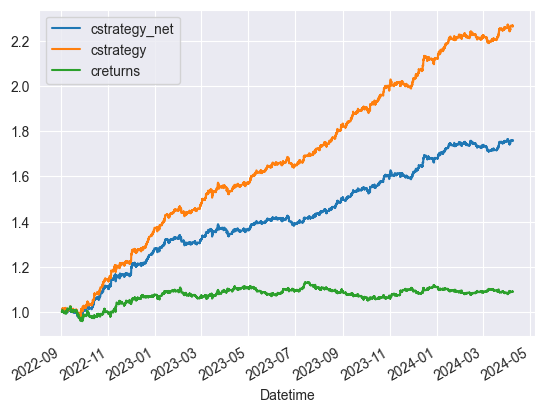

In [433]:
train['probability'] = model.predict(train_standardized[features])
threshold = 0.53
train['position'] = np.where(train.probability < (1-threshold), -1, np.nan)
train['position'] = np.where(train.probability > threshold, 1, train.position)
train['position'] = train.position.ffill()
train['strategy'] = train['position'] * train['returns']
train['creturns'] = train['returns'].cumsum().apply(np.exp)
train['cstrategy'] = train['strategy'].cumsum().apply(np.exp)
train['trades'] = train.position.diff().abs()
train['strategy_net'] = train.strategy - train.trades * ptc
train['cstrategy_net'] = train['strategy_net'].cumsum().apply(np.exp)
train[['cstrategy_net', 'cstrategy', 'creturns']].plot()

In [434]:
print(f"Loss: {loss_train}")
print(f"Accuracy: {accuracy_train}")

Loss: 0.6895784735679626
Accuracy: 0.5617760419845581


In [435]:
print(f"Loss: {loss_test}")
print(f"Accuracy: {accuracy_test}")

Loss: 0.6919362545013428
Accuracy: 0.5522145628929138


<Axes: >

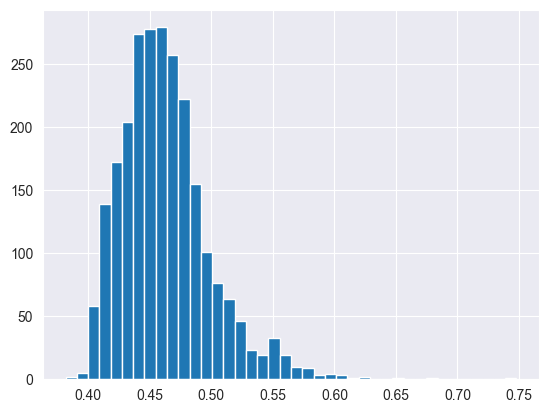

In [436]:
test.probability.hist(bins=40)

<Axes: xlabel='Datetime'>

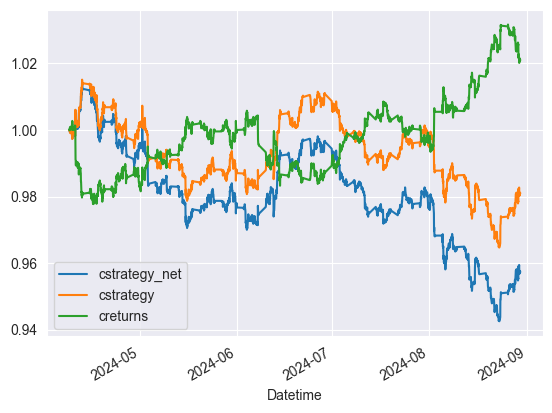

In [437]:
test[['cstrategy_net', 'cstrategy', 'creturns']].plot()

In [438]:
test[['cstrategy_net', 'cstrategy', 'creturns']].iloc[-1]

cstrategy_net    0.957277
cstrategy        0.980956
creturns         1.021057
Name: 2024-08-29 22:00:00+00:00, dtype: float64

In [439]:
test['prediction_dir'] = np.select(
    [test['probability'] < 0.5, test['probability'] > 0.5],
    [0, 1],
    default=np.nan
)

percentage_equal = (test['dir'] == test['prediction_dir']).mean() * 100
percentage_equal

55.22145469321414

In [440]:


percentage_wrong = (test['dir'] == - test['prediction_dir']).mean() * 100
percentage_wrong

49.37017472572125

 33/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 0.5131003648934471
Prediction_local [0.45210324]
Right: 0.46330196


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

<Figure size 5000x5000 with 0 Axes>

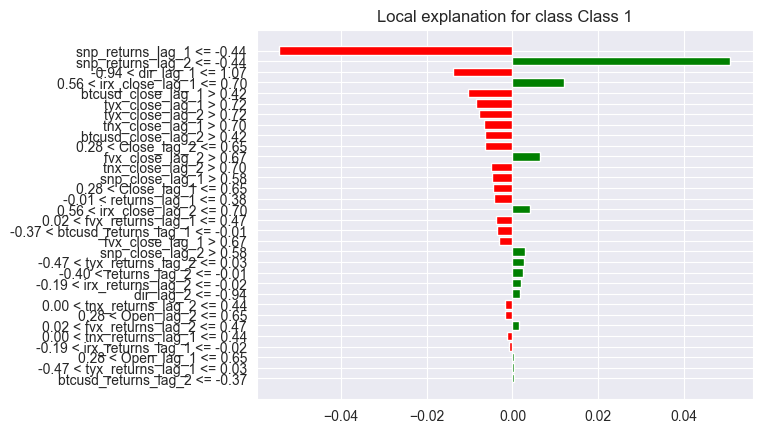

In [441]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_standardized[features]),
    mode='classification',
    feature_names=features,
    class_names=['Class 0', 'Class 1'],  # Assuming binary classification
    verbose=True,
    random_state=42
)

# Define a new predict function to return probabilities for both classes
def predict_fn(X):
    probs = model.predict(X)  # Assuming `model.predict` returns probabilities for one class
    return np.hstack((1 - probs, probs))

# Pick a test instance to explain
i = 12  # Index of the test instance
exp = explainer.explain_instance(
    data_row=test_standardized[features].iloc[i],
    predict_fn=predict_fn,  # Modified predict function
    num_features=len(features)
)

# Create a figure to display the explanation
plt.figure(figsize=(50, 50))  # Adjust the height (second value) as needed

# Show explanation in the notebook
exp.show_in_notebook(show_table=False)

# Generate and display the explanation as a plot
fig = exp.as_pyplot_figure()

# Update font size in the plot and display it
plt.rcParams.update({'font.size': 10})  # Adjust the number as needed
plt.show()

In [442]:
test.creturns.corr(test.cstrategy)

-0.8739651481334534

In [443]:
test

,snp_close,snp_returns,irx_close,irx_returns,fvx_close,fvx_returns,tyx_close,tyx_returns,tnx_close,tnx_returns,...,dir_lag_2,probability,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net,prediction_dir
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-04-08 14:00:00+00:00,5213.040039,-0.000113,5.223,0.000575,4.430,0.003845,4.562,0.002414,4.428,0.003167,...,1.0,0.459598,-1.0,-0.000109,1.000109,0.999891,NaN,NaN,NaN,0.0
2024-04-08 15:00:00+00:00,5203.689941,-0.001795,5.223,0.000000,4.432,0.000451,4.558,-0.000877,4.428,0.000000,...,1.0,0.405592,-1.0,-0.000000,1.000109,0.999891,0.0,-0.000000,1.000000,0.0
2024-04-08 16:00:00+00:00,5210.540039,0.001316,5.223,0.000000,4.436,0.000902,4.562,0.000877,4.430,0.000452,...,1.0,0.432243,-1.0,0.000217,0.999891,1.000109,0.0,0.000217,1.000217,0.0
2024-04-08 17:00:00+00:00,5210.180176,-0.000069,5.223,0.000000,4.429,-0.001579,4.554,-0.001755,4.422,-0.001807,...,0.0,0.508117,-1.0,-0.000760,1.000652,0.999349,0.0,-0.000760,0.999457,1.0
2024-04-08 18:00:00+00:00,5210.640137,0.000088,5.223,0.000000,4.434,0.001128,4.553,-0.000220,4.424,0.000452,...,0.0,0.444277,-1.0,0.000109,1.000543,0.999457,0.0,0.000109,0.999566,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-29 18:00:00+00:00,5601.319824,-0.002658,4.965,0.000000,3.668,0.000000,4.151,0.000964,3.867,0.001035,...,0.0,0.430339,-1.0,0.000443,1.021057,0.980739,0.0,0.000443,0.957290,0.0
2024-08-29 19:00:00+00:00,5591.959961,-0.001672,4.965,0.000000,3.668,0.000000,4.151,0.000964,3.867,0.001035,...,1.0,0.445250,-1.0,0.000332,1.020718,0.981065,0.0,0.000332,0.957609,0.0
2024-08-29 20:00:00+00:00,5591.959961,-0.001672,4.965,0.000000,3.668,0.000000,4.151,0.000964,3.867,0.001035,...,0.0,0.551787,1.0,0.000111,1.020831,0.981173,2.0,-0.000007,0.957602,1.0
